## Analiza COUNT(Age > 50) cu SmartNoise SQL si Global DP

Acest experiment testeaza mecanismul Laplace pentru interogarea COUNT(Age > 50) folosind SmartNoise SQL prin serverul Lomas.

Scopul este sa verificam cum variaza precizia rezultatului in functie de parametrul epsilon atunci cand zgomotul DP este aplicat centralizat (Global DP).

,epsilon,rezultat,eroare,acceptabil
0,0.01,-115,194,False
1,0.05,71,8,False
2,0.10,49,30,False
3,0.20,72,7,False
4,0.30,73,6,False
5,0.50,72,7,False
6,0.70,70,9,False
7,1.00,71,8,False
8,2.00,72,7,False
9,3.00,72,7,False


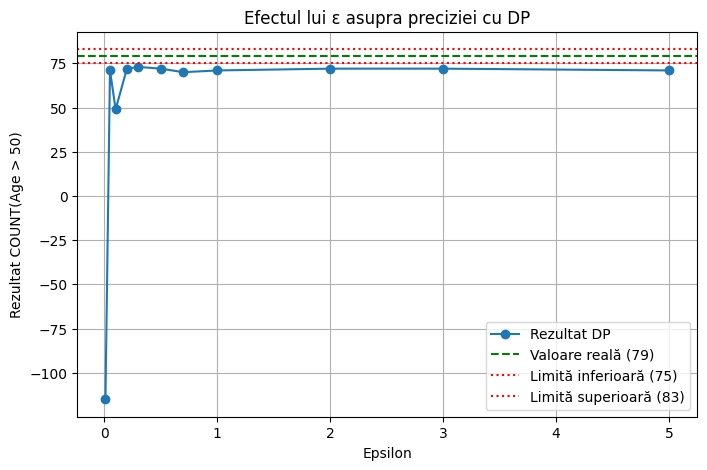

Epsilon minim care oferă rezultat acceptabil (±5%): nan


In [2]:
from lomas_client.client import Client
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Inițializează clientul
client = Client(
    url="http://lomas_server_dev",
    user_name="Jack",
    dataset_name="TITANIC"
)

# Funcție pentru interogare COUNT cu DP
def interogare_count(age_limit, epsilon):
    body = {
        "dataset_name": "TITANIC",
        "epsilon": epsilon,
        "delta": 0.0001,
        "mechanisms": {"count": "laplace"},
        "postprocess": True,
        "query_str": f"SELECT COUNT(*) AS NB_ROW FROM df WHERE Age > {age_limit}"
    }
    headers = {"user-name": "Jack"}
    r = requests.post("http://lomas_server_dev/smartnoise_sql_query", json=body, headers=headers)
    return r.json()

# Parametri
valoare_real = 79
interval_acceptabil = (75, 83)
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0, 5.0]
rezultate = []

# Execută testele pe fiecare epsilon
for eps in epsilons:
    raspuns = interogare_count(50, eps)
    rezultat_dp = raspuns['result']['df']['data'][0][0]
    in_interval = interval_acceptabil[0] <= rezultat_dp <= interval_acceptabil[1]
    eroare = abs(rezultat_dp - valoare_real)
    rezultate.append({
        "epsilon": eps,
        "rezultat": rezultat_dp,
        "eroare": eroare,
        "acceptabil": in_interval
    })

# Afișează tabelul
df_tabel = pd.DataFrame(rezultate)
display(df_tabel)

# Afișează graficul
plt.figure(figsize=(8,5))
plt.plot(df_tabel["epsilon"], df_tabel["rezultat"], marker='o', label="Rezultat DP")
plt.axhline(y=valoare_real, color='green', linestyle='--', label="Valoare reală (79)")
plt.axhline(y=75, color='red', linestyle=':', label="Limită inferioară (75)")
plt.axhline(y=83, color='red', linestyle=':', label="Limită superioară (83)")
plt.xlabel("Epsilon")
plt.ylabel("Rezultat COUNT(Age > 50)")
plt.title("Efectul lui ε asupra preciziei cu DP")
plt.grid(True)
plt.legend()
plt.show()

# Afișează epsilon minim acceptabil
minim_acceptabil = df_tabel[df_tabel["acceptabil"] == True]["epsilon"].min()
print(f"Epsilon minim care oferă rezultat acceptabil (±5%): {minim_acceptabil}")